In [1]:
!pip install chromadb
!pip install open-clip-torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.3/584.3 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.8/273.8 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 70.7 MB/s eta 0:00:0

In [2]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction

In [41]:
embedding_function = OpenCLIPEmbeddingFunction()

def get_single_image_embedding(image):
    embedding = embedding_function._encode_image(image=image)
    return np.array(embedding)


In [53]:
def plot_results(query_path, ls_path_score, top_n=5, reverse=False):
    # Sort the results based on the score
    ls_path_score.sort(key=lambda x: x[1], reverse=reverse)

    # Display the query image
    query_img = Image.open(query_path)
    plt.figure(figsize=(15, 5))

    # Plot the query image
    plt.subplot(1, top_n + 1, 1)
    plt.imshow(query_img)
    plt.title("Query Image")
    plt.axis('off')

    # Plot the top-N similar images
    for i in range(min(top_n, len(ls_path_score))):  # Ensure not to exceed the available results
        img_path, score = ls_path_score[i]
        img = Image.open(img_path)
        plt.subplot(1, top_n + 1, i + 2)
        plt.imshow(img)
        plt.title(f"Score: {score:.2f}")
        plt.axis('off')

    plt.show()

In [7]:
ROOT = 'data'
CLASS_NAME = sorted(list(os.listdir(f"{ROOT}/train")))

In [14]:
def read_image_from_path(path, size):
    im = Image.open(path).convert('RGB').resize(size)
    return np.array(im)

In [11]:
def folder_to_images(folder, size):
    list_dir = [folder + '/' + name for name in os.listdir(folder)]
    images_np = np.zeros(shape=(len(list_dir), *size, 3))
    images_path = []
    for i, path in enumerate(list_dir):
        images_np[i] = read_image_from_path(path, size)
        images_path.append(path)
    images_path = np.array(images_path)
    return images_np, images_path

In [19]:
def get_l1_score(root_img_path, query_path, size):
    query = read_image_from_path(query_path, size)
    query_embedding = get_single_image_embedding(query)
    ls_path_score = []

    for folder in os.listdir(root_img_path):
        if folder in CLASS_NAME:
            path = os.path.join(root_img_path, folder)
            images_np, images_path = folder_to_images(path, size)  # Convert folder to numpy array of images and their paths

            embedding_list = []
            for idx_img in range(images_np.shape[0]):
                embedding = get_single_image_embedding(images_np[idx_img].astype(np.uint8))
                embedding_list.append(embedding)

            rates = absolute_difference(query_embedding, np.stack(embedding_list))
            ls_path_score.extend(list(zip(images_path, rates)))

    return query, ls_path_score


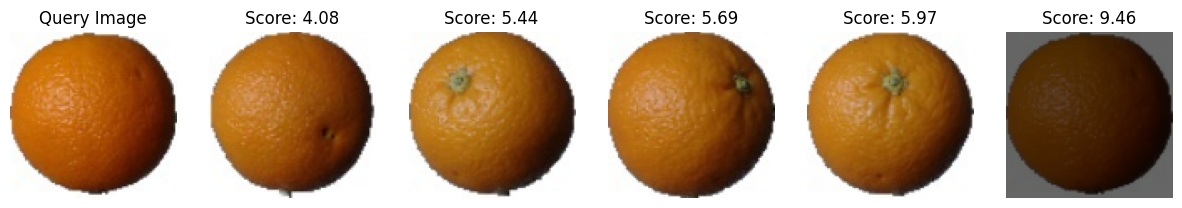

In [20]:
# Define your root image paths and query path
root_img_path = f"{ROOT}/train/"
query_path = f"{ROOT}/test/Orange_easy/0_100.jpg"
size = (448, 448)

# Get the L1 score results
query, ls_path_score = get_l1_score(root_img_path, query_path, size)

# Plot the results
plot_results(query_path, ls_path_score, reverse=False)


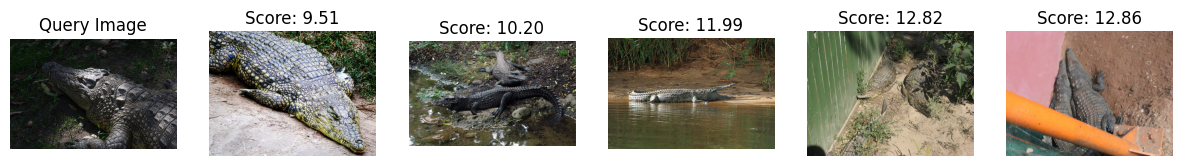

In [21]:
# L1-Score for complex images
root_img_path = f"{ROOT}/train/"
query_path = f"{ROOT}/test/African_crocodile/n01697457_18534.JPEG"
size = (448, 448)
query, ls_path_score = get_l1_score(root_img_path, query_path, size)
plot_results(query_path, ls_path_score, reverse=False)

In [22]:
def get_l2_score(root_img_path, query_path, size):
    query = read_image_from_path(query_path, size)
    query_embedding = get_single_image_embedding(query)
    ls_path_score = []

    for folder in os.listdir(root_img_path):
        if folder in CLASS_NAME:
            path = os.path.join(root_img_path, folder)
            images_np, images_path = folder_to_images(path, size)  # Convert folder to numpy array of images and their paths

            embedding_list = []
            for idx_img in range(images_np.shape[0]):
                embedding = get_single_image_embedding(images_np[idx_img].astype(np.uint8))
                embedding_list.append(embedding)

            rates = mean_square_difference(query_embedding, np.stack(embedding_list))
            ls_path_score.extend(list(zip(images_path, rates)))

    return query, ls_path_score


In [25]:
def mean_square_difference(embedding1, embedding2):
    return np.sqrt(np.sum((embedding1 - embedding2) ** 2, axis=1))


def get_l2_score(root_img_path, query_path, size):
    query = read_image_from_path(query_path, size)
    query_embedding = get_single_image_embedding(query)
    ls_path_score = []

    for folder in os.listdir(root_img_path):
        if folder in CLASS_NAME:
            path = os.path.join(root_img_path, folder)
            images_np, images_path = folder_to_images(path, size)  # Convert folder to numpy array of images and their paths

            embedding_list = []
            for idx_img in range(images_np.shape[0]):
                embedding = get_single_image_embedding(images_np[idx_img].astype(np.uint8))
                embedding_list.append(embedding)

            rates = mean_square_difference(query_embedding, np.stack(embedding_list))
            ls_path_score.extend(list(zip(images_path, rates)))

    return query, ls_path_score


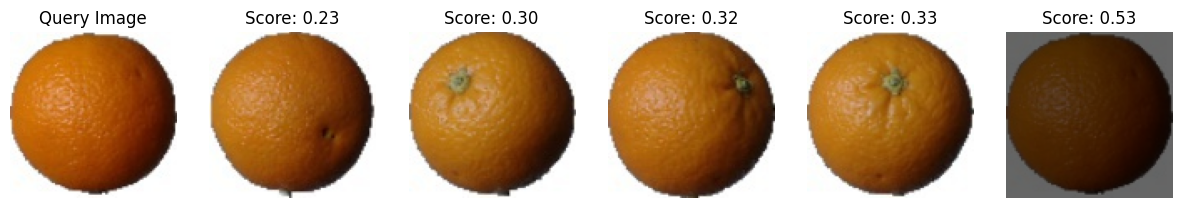

In [26]:
# L2-Score for simple images
root_img_path = f"{ROOT}/train/"
query_path = f"{ROOT}/test/Orange_easy/0_100.jpg"
size = (448, 448)
query, ls_path_score = get_l2_score(root_img_path, query_path, size)
plot_results(query_path, ls_path_score, reverse=False)

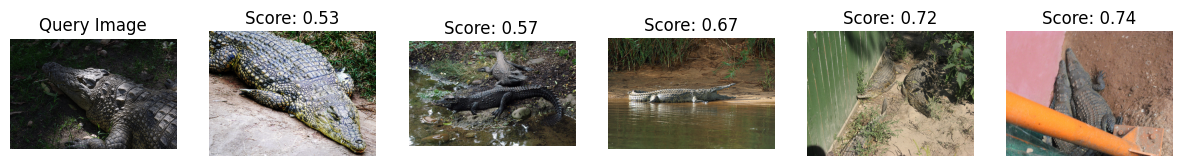

In [27]:
# L2-Score for complex images
root_img_path = f"{ROOT}/train/"
query_path = f"{ROOT}/test/African_crocodile/n01697457_18534.JPEG"
size = (448, 448)
query, ls_path_score = get_l2_score(root_img_path, query_path, size)
plot_results(query_path, ls_path_score, reverse=False)

In [29]:
def cosine_similarity(embedding1, embedding_list):
    # Normalize the embeddings
    embedding1_norm = embedding1 / np.linalg.norm(embedding1)
    embedding_list_norm = embedding_list / np.linalg.norm(embedding_list, axis=1, keepdims=True)

    # Calculate the cosine similarity
    return np.dot(embedding_list_norm, embedding1_norm.T)


def get_cosine_similarity_score(root_img_path, query_path, size):
    query = read_image_from_path(query_path, size)
    query_embedding = get_single_image_embedding(query)
    ls_path_score = []

    for folder in os.listdir(root_img_path):
        if folder in CLASS_NAME:
            path = os.path.join(root_img_path, folder)
            images_np, images_path = folder_to_images(path, size)  # Convert folder to numpy array of images and their paths

            embedding_list = []
            for idx_img in range(images_np.shape[0]):
                embedding = get_single_image_embedding(images_np[idx_img].astype(np.uint8))
                embedding_list.append(embedding)

            rates = cosine_similarity(query_embedding, np.stack(embedding_list))
            ls_path_score.extend(list(zip(images_path, rates)))

    return query, ls_path_score


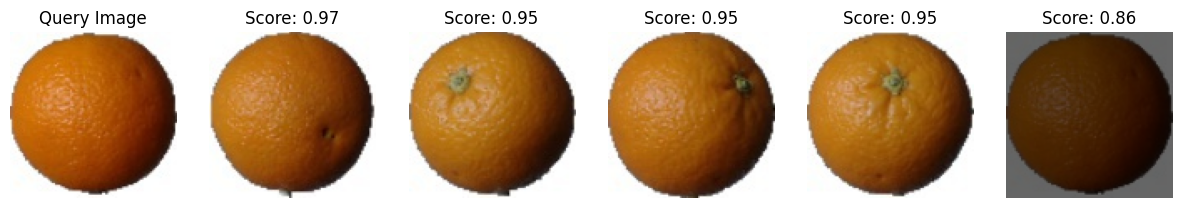

In [30]:
# Cosine-similarities for simple images
root_img_path = f"{ROOT}/train/"
query_path = f"{ROOT}/test/Orange_easy/0_100.jpg"
size = (448, 448)
query, ls_path_score = get_cosine_similarity_score(root_img_path, query_path, size)
plot_results(query_path, ls_path_score, reverse=True)

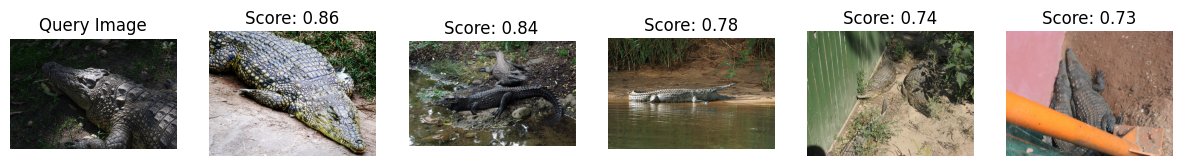

In [31]:
# Cosine-similarities for complex images
root_img_path = f"{ROOT}/train/"
query_path = f"{ROOT}/test/African_crocodile/n01697457_18534.JPEG"
size = (448, 448)
query, ls_path_score = get_cosine_similarity_score(root_img_path, query_path, size)
plot_results(query_path, ls_path_score, reverse=True)

In [35]:
def correlation_coefficient(query_embedding, embedding_list):
    # Ensure the embeddings are in the correct shape
    query_embedding = query_embedding.squeeze()

    # Compute the correlation coefficient for each embedding
    correlation_scores = []
    for embedding in embedding_list:
        # Flatten embeddings to ensure they are 1D
        query_embedding_flat = query_embedding.flatten()
        embedding_flat = embedding.flatten()

        # Calculate the Pearson correlation coefficient
        correlation = np.corrcoef(query_embedding_flat, embedding_flat)[0, 1]
        correlation_scores.append(correlation)

    return np.array(correlation_scores)


def get_correlation_coefficient_score(root_img_path, query_path, size):
    query = read_image_from_path(query_path, size)
    query_embedding = get_single_image_embedding(query)
    ls_path_score = []

    for folder in os.listdir(root_img_path):
        if folder in CLASS_NAME:
            path = os.path.join(root_img_path, folder)
            images_np, images_path = folder_to_images(path, size)  # Convert folder to numpy array of images and their paths

            embedding_list = []
            for idx_img in range(images_np.shape[0]):
                embedding = get_single_image_embedding(images_np[idx_img].astype(np.uint8))
                embedding_list.append(embedding)

            rates = correlation_coefficient(query_embedding, np.stack(embedding_list))
            ls_path_score.extend(list(zip(images_path, rates)))

    return query, ls_path_score


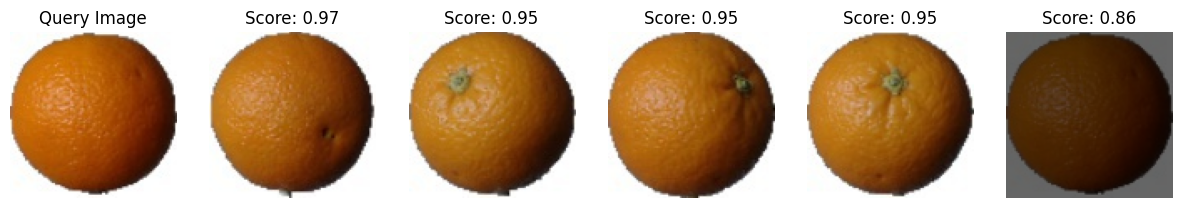

In [36]:
# Correlation-Coefficient for simple images
root_img_path = f"{ROOT}/train/"
query_path = f"{ROOT}/test/Orange_easy/0_100.jpg"
size = (448, 448)
query, ls_path_score = get_correlation_coefficient_score(root_img_path, query_path, size)
plot_results(query_path, ls_path_score, reverse=True)

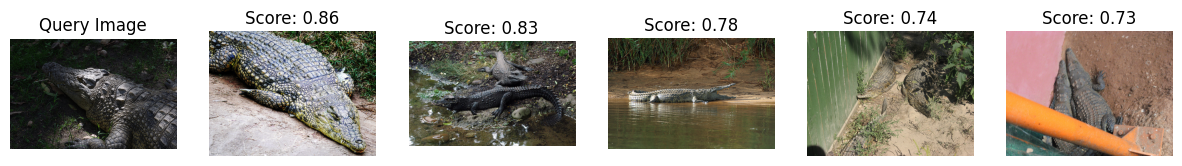

In [37]:
# Correlation-Coefficient for complex images
root_img_path = f"{ROOT}/train/"
query_path = f"{ROOT}/test/African_crocodile/n01697457_18534.JPEG"
size = (448, 448)
query, ls_path_score = get_correlation_coefficient_score(root_img_path, query_path, size)
plot_results(query_path, ls_path_score, reverse=True)

In [38]:
def get_files_path(path):
    files_path = []
    for label in CLASS_NAME:
        label_path = os.path.join(path, label)
        filenames = os.listdir(label_path)
        for filename in filenames:
            filepath = os.path.join(label_path, filename)
            files_path.append(filepath)
    return files_path

data_path = f'{ROOT}/train'
files_path = get_files_path(path=data_path)


In [46]:
from tqdm import tqdm
from PIL import Image
import numpy as np

def add_embedding(collection, files_path):
    ids = []
    embeddings = []
    for id_filepath, filepath in tqdm(enumerate(files_path)):
        ids.append(f'id_{id_filepath}')
        image = Image.open(filepath)
        image_array = np.array(image)  # Convert to a NumPy array

        embedding = get_single_image_embedding(image=image_array)
        embedding_list = embedding.tolist()  # Convert NumPy array to list

        embeddings.append(embedding_list)

    collection.add(
        embeddings=embeddings,
        ids=ids
    )


In [47]:
# Import necessary modules
import chromadb

# Create a Chroma Client
chroma_client = chromadb.Client()

# Create a collection with the L2 distance metric
l2_collection = chroma_client.get_or_create_collection(
    name="l2_collection",
    metadata={"HNSW_SPACE": "l2"}
)

# Add embeddings to the collection
add_embedding(collection=l2_collection, files_path=files_path)


595it [01:43,  5.76it/s]


In [50]:
def search(image_path, collection, n_results):
    # Open the image and convert it to the format required by the embedding function
    query_image = Image.open(image_path)
    query_image_array = np.array(query_image)  # Convert to a NumPy array if needed

    # Get the embedding for the query image
    query_embedding = get_single_image_embedding(query_image_array)
    query_embedding_list = query_embedding.tolist()  # Convert NumPy array to list

    # Perform the query against the collection
    results = collection.query(
        query_embeddings=[query_embedding_list],  # Pass the embedding as a list
        n_results=n_results  # Specify how many results to return
    )

    return results


In [56]:
def plot_results(query_path, ls_path_score, top_n=5, reverse=False):
    # Extract the results (assuming `ls_path_score` is a dict with 'documents' or similar key)
    results = ls_path_score.get('documents', [])

    # Sort the results based on the score
    results.sort(key=lambda x: x['score'], reverse=reverse)

    # Display the query image
    query_img = Image.open(query_path)
    plt.figure(figsize=(15, 5))

    # Plot the query image
    plt.subplot(1, top_n + 1, 1)
    plt.imshow(query_img)
    plt.title("Query Image")
    plt.axis('off')

    # Plot the top-N similar images
    for i in range(min(top_n, len(results))):
        img_path = results[i]['filepath']  # Adjust based on the actual key for the image path
        score = results[i]['score']        # Adjust based on the actual key for the score
        img = Image.open(img_path)
        plt.subplot(1, top_n + 1, i + 2)
        plt.imshow(img)
        plt.title(f"Score: {score:.2f}")
        plt.axis('off')

    plt.show()


In [58]:
# Define the test path
test_path = f'{ROOT}/test'

# Get the file paths for the test images
test_files_path = get_files_path(path=test_path)

# Select a specific test image (second in the list)
test_image_path = test_files_path[1]

# Perform the search on the L2 collection with the selected test image
l2_results = search(image_path=test_image_path, collection=l2_collection, n_results=5)

# Plot the results
plot_results(query_path=test_image_path, ls_path_score=l2_results, top_n=5, reverse=False)


TypeError: list indices must be integers or slices, not str

In [ ]:
# Create a collection with Cosine similarity
cosine_collection = chroma_client.get_or_create_collection(
    name="Cosine_collection",
    metadata={"HNSW_SPACE": "cosine"}  # Specify that the collection uses cosine similarity
)

# Add embeddings to the collection
add_embedding(collection=cosine_collection, files_path=files_path)


348it [01:00,  5.94it/s]